# BioSound Tutorial 4.  Supervised Classification with BioSound properties.
### This notebook illustrates how to perform LDA, QDA and RF on data that has been pre-processed by BioSound.

LDA : Linear Discriminant Analysis  
QDA : Quadratic Discriminant Analysis  
RF  : Random Forest  

At this stage, you have transformed all your sound files into BioSound objects and generated a pandas table where you have saved the parameters of interest as in tutorial 3.

## Step 1. Loading all the dependencies.  
### numpy, soundsig and pandas. 

In [1]:
# Import math, pandas and soundsig libraries
import numpy as np
import pandas as pd
#from soundsig.discriminate import discriminatePlot

# Import local soundsig.discriminate because costum functionality
import sys
sys.path.append('./soundsig/soundsig')
from discriminate import discriminatePlot

# Make plots on this Notebook.
%matplotlib inline


## Step 2. Specifying the pandas table and reading it.

You will want to change the location for storing the pandas table to the one you specified in tutorial 3.

In [9]:
# The pandas data frame location (from tutorial 3 and moved manually to server):
tableStore = "Z:\\users\\JulieE\\DeafSalineGroup151\\DeafBats_BioSoundTutorialNotebooksData\\vocSelTable.h5"

# This is where you want to store eps of figures that will be generated.
figdir = './'

# Let's read it:
vocSelTable = pd.read_hdf(tableStore)

## Add the deaf versus control labels

Use the labels from Julie

In [15]:
BatStatus_name = ['F11648', 'M14461', 'F14463', 'M14464', 'F65696', 'M71043', 'F71047', 'M71351', 'F71353', 'F71354'];
BatStatus_sex = ['F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'F'];
BatStatus_deaf = [0, 0, 1, 0, 0, 1, 1, 1, 0, 1];

# Initialize name-deaf_status dict
bat_name_to_deaf_dict = dict(zip(BatStatus_name,BatStatus_deaf))
bat_name_to_sex_dict = dict(zip(BatStatus_name, BatStatus_sex))

# Add deaf status to dictionary
print(vocSelTable.columns)
vocSelTable['isDeaf'] =  vocSelTable['Bird'].map(bat_name_to_deaf_dict) # Bird is actually Bat ID. 
print(vocSelTable['isDeaf'] )

# Add sex to table
vocSelTable['sex'] =  vocSelTable['Bird'].map(bat_name_to_sex_dict) # Bird is actually Bat ID. 
print(vocSelTable['sex'] )

print(vocSelTable)

Index(['Bird', 'calltype', 'fund', 'cvfund', 'maxfund', 'minfund', 'F1', 'F2',
       'F3', 'sal', 'rms', 'maxAmp', 'meanS', 'stdS', 'skewS', 'kurtS', 'entS',
       'q1', 'q2', 'q3', 'meanT', 'stdT', 'skewT', 'kurtT', 'entT', 'isDeaf',
       'sex'],
      dtype='object')
0       0
1       0
2       0
3       0
4       0
       ..
5159    1
5160    1
5161    1
5162    1
5163    1
Name: isDeaf, Length: 5164, dtype: int64
0       F
1       F
2       F
3       F
4       F
       ..
5159    M
5160    M
5161    M
5162    M
5163    M
Name: sex, Length: 5164, dtype: object
        Bird calltype         fund    cvfund      maxfund      minfund  \
0     F11648       Sa          NaN       NaN          NaN          NaN   
1     F11648       Sa          NaN       NaN          NaN          NaN   
2     F11648       Sa          NaN       NaN          NaN          NaN   
3     F11648       Sa  3183.856379  0.000157  3184.995118  3183.455710   
4     F11648       Sa  3719.780623  0.043081  3960.27334

In [11]:
print(type(vocSelTable['Bird']))

<class 'pandas.core.series.Series'>


## Step 3. Supervised Classification with cross-validation.  

Here we are going to see how well bird id can be classified using lda, qda and rf.  The routine discriminatePlot fits these supervised classifiers after pre-processing.  The pre-processing involves removing groups that have insufficent data and performing a PCA on the features used by the classifier as a form of regularization (to prevent overfitting).  The PCA is performed when there is insufficent data in each group to get good estimates of the within group covariance matrix.  The performance of the classifiers using 10 fold cross-validation.  Alternatively, one can specify indexes that will be used uniquely in the testing set of the classifiers (testInd - see discriminatePlot() in soundsig/discriminate.  


3       F11648
4       F11648
7       F11648
8       F11648
9       F11648
         ...  
5154    M71351
5155    M71351
5156    M71351
5157    M71351
5159    M71351
Name: Bird, Length: 2999, dtype: object
Variance explained is 100.00%
doing group holdout
LDA Weights:
DFA 0: entT 4.268; sal -2.308; entS 0.752; skewS 0.449; meanT 0.432; 


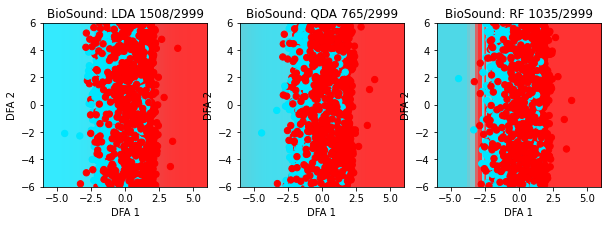

Number of classes 2. Chance level 50.00 %
BioSound LDA: 50.28 % (1508/2999 p=0.3851)
BioSound QDA: 25.51 % (765/2999 p=1.0000)
BioSound RF: 34.51 % (1035/2999 p=1.0000)


c:\users\tobias\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


<Figure size 432x288 with 0 Axes>

In [17]:
#  Here we generate colors for each bird for plotting purposes:

# Color code for bird ID
birdColorStart = [(0/255.0, 230/255.0, 255/255.0),  
             (255/255.0, 0/255.0, 0/255.0), 
             (255/255.0, 180/255.0, 255/255.0),
             (140/255.0, 100/255.0, 185/255.0) ]



bird_classes = np.unique(vocSelTable['isDeaf'])

# If you have a small number of birds you might want to choose specific colors
birdColor = {}
ib = 0
for birdId in bird_classes:
    if ib < 4:
       birdColor[birdId] = birdColorStart[ib] 
    else:
       birdColor[birdId] = np.random.rand(3)
    ib += 1
    
cValBirdAll = []
for birdId in vocSelTable['isDeaf']:
    cValBirdAll.append(birdColor[birdId])
    
cValBirdAll = np.asarray(cValBirdAll)


# Can we classify bird_class using the average formants, pitch saliency, fundamental and the cv fund ?

# X is the data array of features.
# y is the variable name for the grouping variable 
#XFeatureNames = np.hstack(('F1', 'F2', 'F3', 'sal', 'fund','cvfund'))
XFeatureNames = np.hstack(('fund', 'cvfund', 'maxfund', 'minfund', 'F1', 'F2',
       'F3', 'sal', 'rms', 'maxAmp', 'meanS', 'stdS', 'skewS', 'kurtS', 'entS',
       'q1', 'q2', 'q3', 'meanT', 'stdT', 'skewT', 'kurtT', 'entT'))

X = [vocSelTable.loc[:,col] for col in XFeatureNames ]
X = np.stack(X, axis=1)

y = np.array(vocSelTable['isDeaf'])

# Exclude entries that have nan
nonanInd = (np.sum(np.isnan(X), axis = 1) == 0)

groups = vocSelTable['Bird'][nonanInd]
print(groups)

# Formants + Saliency + Fund Model 
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, nClasses, weights, weights_all = discriminatePlot(X[nonanInd], y[nonanInd], 
                                                                                            cValBirdAll[nonanInd], 
                                                                                            Xcolname = XFeatureNames,
                                                                                            titleStr = 'BioSound',
                                                                                            figdir = figdir,
                                                                                            plotFig = True,
                                                                                            group_hold_out = groups)
d = {'Type': np.array(['CallerAdult']),
     'Features': np.array(['Formants + Fund']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP])}
     
resultsDataFrame = pd.DataFrame(data = d)

### Let's perform a second discrimination without using the formants.

Are formants helpful (beyond fundamental) to discriminate bird id?

In [ ]:
# X is the data array of features.
# y is the variable name for the grouping variable 

XFeatureNames = np.hstack(('sal', 'fund','cvfund','meanS','rms'))
X = [vocSelTable.loc[:,col] for col in XFeatureNames ]
X = np.stack(X, axis=1)

y = np.array(vocSelTable['calltype'])

# Exclude entries that have nan
nonanInd = (np.sum(np.isnan(X), axis = 1) == 0)

# Formants + Fund Model
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, nClasses, weights = discriminatePlot(X[nonanInd], y[nonanInd], 
                                                                                            cValBirdAll[nonanInd],
                                                                                            Xcolname = XFeatureNames,
                                                                                            titleStr = 'Fund',
                                                                                            figdir = figdir,
                                                                                            plotFig = True)
d = {'Type': np.array(['CallerAdult']),
     'Features': np.array(['Fund']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP])}

tempdf = pd.DataFrame(data=d)
resultsDataFrame.append(tempdf)

In this case, it can be seen that very similar discrimination is obtained using only fundamental parameters (and saliency).  The performance of the three classifiers is almost identical.



In [ ]:
# Find the average window length of a bat call
